## Data Pre Processing

In [16]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
from tensorflow.keras import regularizers

# Function to eliminate rows with empty values 

def eliminate_empty_values(df): 
    for col in df.columns:
       df[col].replace('', np.nan, inplace=True)

    for col in df.columns:
        df.dropna(subset=[col], inplace=True)            
            
    return df

# Function to create binary levels. 0 = Healthy PM2.5 values, 1 = Unhealthy Values 

def create_label(df): 
    
    df['label'] = np.where(df['PM_US Post'] <120 , 0, 1)
    df.drop(['PM_US Post'], 
               axis=1,
              inplace=True)
    return df

# Function to load the CSV data

def load_data(csv): 
    city = pd.read_csv(csv)
    period = pd.PeriodIndex(year=city["year"],month=city["month"],day=city["day"],freq="D")
    city["datetime"] = period.strftime('%Y-%m-%d')
    labelEncoder=preprocessing.LabelEncoder()
    city['cbwd']=labelEncoder.fit_transform(city['cbwd']) # This value is not numerical and has to be Label Encoded 
    return city 

shanghai = load_data("data/ShanghaiPM20100101_20151231.csv")

# We delete the rows that are not neccessary for prediction

shanghai.drop(['PM_Jingan', 'PM_Xuhui', 'month', 'day', 'hour'], axis=1,inplace=True) 

shanghai.reset_index(inplace=True)
shanghai = eliminate_empty_values(shanghai)

# Calculating the mean of PM2.5 for that day 

shanghai = shanghai.groupby(['datetime']).mean()
training_set = shanghai[['PM_US Post','season', 'DEWP','HUMI','PRES','TEMP','cbwd','Iws','precipitation','Iprec']]
training_set.reset_index(inplace=True)


In [17]:
# Select features (columns) to be involved intro training and predictions

cols = list(training_set)[1:11]
training_dates = []

# Extractinf dates for visualization purposes

training_dates = list(training_set['datetime'])
dates = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in training_dates]

print('Training set shape == {}'.format(training_set.shape))
print('Featured selected: {}'.format(cols))

Training set shape == (1415, 11)
Featured selected: ['PM_US Post', 'season', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec']


In [18]:
# Converting our training set into Matrices 

training_set = training_set[cols].astype(float)
training_set = training_set.values

print('Shape of training set == {}.'.format(training_set.shape))

Shape of training set == (1415, 10).


In [19]:
# Scaling the data to improve performance. One scaler for the features and another one for the value we are trying to predict

Scaler = StandardScaler()
training_set_scaled = Scaler.fit_transform(training_set)

PM_Scaler = StandardScaler()
PM_Scaler.fit_transform(training_set[:, 0:1])


array([[-0.48052015],
       [ 0.00804757],
       [-0.25434073],
       ...,
       [ 0.20698093],
       [ 1.46624673],
       [ 2.35542183]])

In [14]:
# Creating the training structure with sliding window timestamps and 1 output

X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future (2 months)
n_past = 15     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:training_set.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
print('X_train shape =',(X_train.shape))
print('y_train shape =',(y_train.shape))    

X_train shape = (1341, 15, 9)
y_train shape = (1341, 1)


## Creating Model

In [6]:
# Initializing the Sequential Model

model = Sequential()

# First LSTM layer

model.add(LSTM(units=32, return_sequences=True, input_shape=(n_past, training_set.shape[1]-1)))

# Second LSTMlayer

model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout to help with overfitting  

model.add(Dropout(0.35))

# Linear layer

model.add(Dense(units=1, activation='linear'))

# Compiling the architecture 

model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 32)            5376      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1720      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 7,107
Trainable params: 7,107
Non-trainable params: 0
_________________________________________________________________


## Training The model

In [7]:
# Training the model
red = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)

history = model.fit(X_train, y_train, shuffle=True, epochs= 80, callbacks= red, validation_split=0.2, verbose=1, batch_size=64)

Epoch 1/80
17/17 [==============================] - 6s 127ms/step - loss: 0.9555 - val_loss: 0.5418
Epoch 2/80
17/17 [==============================] - 0s 18ms/step - loss: 0.8469 - val_loss: 0.5110
Epoch 3/80
17/17 [==============================] - 0s 18ms/step - loss: 0.7874 - val_loss: 0.5236
Epoch 4/80
17/17 [==============================] - 0s 18ms/step - loss: 0.6939 - val_loss: 0.5072
Epoch 5/80
17/17 [==============================] - 1s 40ms/step - loss: 0.8035 - val_loss: 0.5486
Epoch 6/80
17/17 [==============================] - 0s 20ms/step - loss: 0.7959 - val_loss: 0.5586
Epoch 7/80
17/17 [==============================] - 0s 19ms/step - loss: 0.7014 - val_loss: 0.6579
Epoch 8/80
17/17 [==============================] - 1s 35ms/step - loss: 0.6965 - val_loss: 0.5825
Epoch 9/80
17/17 [==============================] - 1s 31ms/step - loss: 0.6944 - val_loss: 0.6203
Epoch 10/80
17/17 [==============================] - 0s 24ms/step - loss: 0.5785 - val_loss: 0.6580
Epoch 11


Epoch 00079: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 80/80
17/17 [==============================] - 0s 17ms/step - loss: 0.1409 - val_loss: 0.9886


## Generate Predictions and Plotting Results

In [9]:
# Generate list of sequence of days for predictions
future_dates = pd.date_range(training_dates[-1], periods=n_future, freq='1d').tolist()

# Generate predictions

y_pred_future_prev = model.predict(X_train[-n_future:])
y_pred_train_prev = model.predict(X_train[n_past:])

In [10]:

y_pred_future = PM_Scaler.inverse_transform(y_pred_future_prev)
y_pred_train = PM_Scaler.inverse_transform(y_pred_train_prev)

predictions_future_pd = pd.DataFrame(y_pred_future, columns=['PM']).set_index(pd.Series(future_dates))
predictions_train_pd = pd.DataFrame(y_pred_train, columns=['PM']).set_index(pd.Series(training_dates[2 * n_past + n_future -1:]))

predictions_train_pd.index = pd.to_datetime(predictions_train_pd.index)


# Parse training set timestamp for better visualization
training_set = pd.DataFrame(training_set, columns=cols)
training_set.index = training_dates
training_set.index = pd.to_datetime(training_set.index)



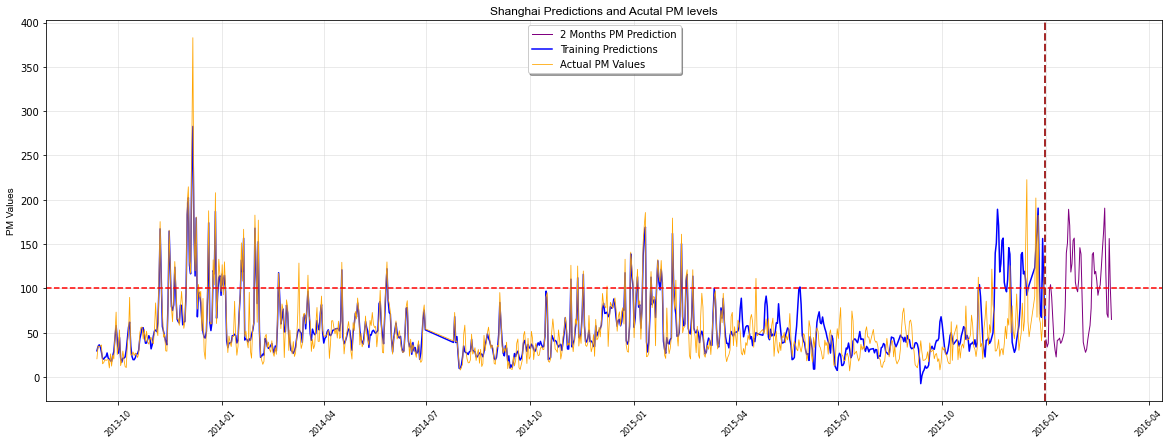

In [11]:
starting_date = '2013-09-12'

from pylab import rcParams
rcParams['figure.figsize'] = 20, 7

plt.plot(predictions_future_pd.index, predictions_future_pd['PM'], color='purple', label='2 Months PM Prediction', linewidth=1)
plt.plot(predictions_train_pd.loc[starting_date:].index, predictions_train_pd.loc[starting_date:]['PM'], color='b', label='Training Predictions')
plt.plot(training_set.loc[starting_date:].index, training_set.loc[starting_date:]['PM_US Post'], color='orange', label='Actual PM Values', linewidth=0.8)

plt.axvline(x = min(predictions_future_pd.index), color='brown', linewidth=2, linestyle='--')
plt.axhline(y= 100, color='r', linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Shanghai Predictions and Acutal PM levels', family='Arial', fontsize=12)
plt.ylabel('PM Values', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()
predictions_train_pd.reset_index(inplace=True)

## Specifying Month and Year for Prediction

In [12]:
Month = 11
Year = 2014
month = predictions_train_pd.loc[(predictions_train_pd['index'].dt.month==Month) & (predictions_train_pd['index'].dt.year==Year)]
print('Predicted Total days of High PM2.5 levels for MONTH (', Month, ') and YEAR(', Year, '):', month[month['PM'] > 100].count()["PM"]) 


Predicted Total days of High PM2.5 levels for MONTH ( 11 ) and YEAR( 2014 ): 3


## Future Prediction

In [13]:
print("Predicted Total days of High PM2.5 levels for the next 2 months:",predictions_future_pd[predictions_future_pd['PM'] > 100].count()["PM"])

Predicted Total days of High PM2.5 levels for the next 2 months: 25
